In [2]:
from pytube import YouTube
import pandas as pd
import cv2
from tqdm import tqdm
import os
music_list = pd.read_csv('/opt/ml/ytdataset/pianoyt.csv', names=["index", "link", "train/test", "crop_minY", "crop_maxY", "crop_minX", "crop_maxX"])


In [3]:
music_list['train/test'].value_counts()

train/test
1    207
3     21
Name: count, dtype: int64

In [6]:
music_list = music_list.iloc[:10]

In [7]:
music_list['train/test'].value_counts()

train/test
1    10
Name: count, dtype: int64

In [9]:
os.makedirs("./videos/train/", exist_ok=True)
os.makedirs("./videos/test/", exist_ok=True)
for _, (is_train, music_link, music_idx) in tqdm(music_list[['train/test', 'link', 'index']].iterrows(), total=music_list.shape[0]):
    if is_train == 1:
        output_path = "./videos/train/"
    else:
        output_path = "./videos/test/"
    try:
        yt = YouTube(music_link)
        yt.streams.filter(mime_type="video/mp4", res="1080p").first().download(output_path=output_path, filename_prefix=f"{music_idx}_")
    except Exception:
        print(f"failed to download : {music_idx}, {music_link}")

100%|██████████| 10/10 [00:42<00:00,  4.25s/it]


In [2]:
import ffmpeg
import os
vid_list_train = sorted(os.listdir("./videos/train"))


In [5]:
vid_name

'137_Schubert 4 Impromptus Op90 - P Barton FEURICH HP piano.mp4'

In [4]:
for vid_name in vid_list_train[:80]:
    idx = int(vid_name.split("_")[0])
    minY, maxY, minX, maxX = music_list[music_list['index']==idx][['crop_minY', 'crop_maxY', 'crop_minX', 'crop_maxX']].values[0]
    vid_path = os.path.join("./videos/train", vid_name)
    vid_obj = ffmpeg.input(vid_path)
    vid_save_path = f"images/train/{vid_name}"
    os.makedirs(vid_save_path, exist_ok=True)
    vid_obj.filter("fps", fps=25).filter("crop", maxX-minX, maxY-minY, minX, minY).filter("scale", "800", "145").output(os.path.join(vid_save_path, "%04d.png"), **{"qmin": 1, "qmax": 1}).run()


ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

KeyboardInterrupt: 

[image2 @ 0x557a090d1320] Could not open file : images/train/137_Schubert 4 Impromptus Op90 - P Barton FEURICH HP piano.mp4/36245.png
av_interleaved_write_frame(): Input/output error
frame=36253 fps=163 q=-0.0 Lsize=N/A time=00:24:09.80 bitrate=N/A speed=6.51x    
video:5179518kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: unknown
Conversion failed!


# Midi to numpy

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
image_fps = 25
sec_per_frame = 1 / image_fps

In [12]:
import mido
from mido import MidiFile
from copy import deepcopy

mid = MidiFile('./pianoyt_MIDI/audio_100.0.midi')
# mid = MidiFile('./MIDItest/miditest_MIDI/5.mid')

In [23]:
mid.tracks

[MidiTrack([
   MetaMessage('set_tempo', tempo=500000, time=0),
   MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
   MetaMessage('end_of_track', time=1)]),
 MidiTrack([
   Message('program_change', channel=0, program=0, time=0),
   Message('note_on', channel=0, note=45, velocity=39, time=4534),
   Message('note_on', channel=0, note=65, velocity=58, time=0),
   Message('note_on', channel=0, note=45, velocity=0, time=84),
   Message('note_on', channel=0, note=52, velocity=48, time=57),
   Message('note_on', channel=0, note=67, velocity=56, time=56),
   Message('note_on', channel=0, note=53, velocity=46, time=14),
   Message('note_on', channel=0, note=65, velocity=0, time=14),
   Message('note_on', channel=0, note=52, velocity=0, time=28),
   Message('note_on', channel=0, note=60, velocity=48, time=14),
   Message('note_on', channel=0, note=52, velocity=41, time=85),
   Message('note_on', channel=0, note=69, velocity=

In [83]:
bpm = mido.tempo2bpm(mid.tracks[0][0].tempo)
bps = bpm / 60.0

sec_per_tick = mid.ticks_per_beat * bps


In [85]:
mid.ticks_per_beat

220

In [84]:
note_str = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
custom_notes = []
curtime = 0
for msg in mid.tracks[1]:
    if hasattr(msg, "note"):
        note_pitch = msg.note
        note_stat = "on" if msg.velocity > 0 else "off"
        curtime += msg.time
        note_time = curtime / sec_per_tick
        custom_notes.append({"status": note_stat, "note": note_pitch, "time(sec)":note_time})

In [86]:
custom_notes[:10]

[{'status': 'on', 'note': 45, 'time(sec)': 10.304545454545455},
 {'status': 'on', 'note': 65, 'time(sec)': 10.304545454545455},
 {'status': 'off', 'note': 45, 'time(sec)': 10.495454545454546},
 {'status': 'on', 'note': 52, 'time(sec)': 10.625},
 {'status': 'on', 'note': 67, 'time(sec)': 10.752272727272727},
 {'status': 'on', 'note': 53, 'time(sec)': 10.784090909090908},
 {'status': 'off', 'note': 65, 'time(sec)': 10.815909090909091},
 {'status': 'off', 'note': 52, 'time(sec)': 10.879545454545454},
 {'status': 'on', 'note': 60, 'time(sec)': 10.911363636363637},
 {'status': 'on', 'note': 52, 'time(sec)': 11.104545454545455}]

In [87]:
def numeric_note_to_string(custom_note):
    custom_note_copy = deepcopy(custom_note)
    for note in custom_note_copy:
        note['note(str)'] = note_str[note['note'] % 12] + str(int(note['note']) // 12)
    return custom_note_copy

In [88]:
# midi drawing
curtime = 0
x = []
y = []
for msg in mid.tracks[1]:
    if hasattr(msg, "note"):
        if msg.velocity != 0:
            y.append(msg.note)
        curtime += msg.time
        if msg.velocity != 0:
            x.append(curtime)

In [94]:
len(x)

1154

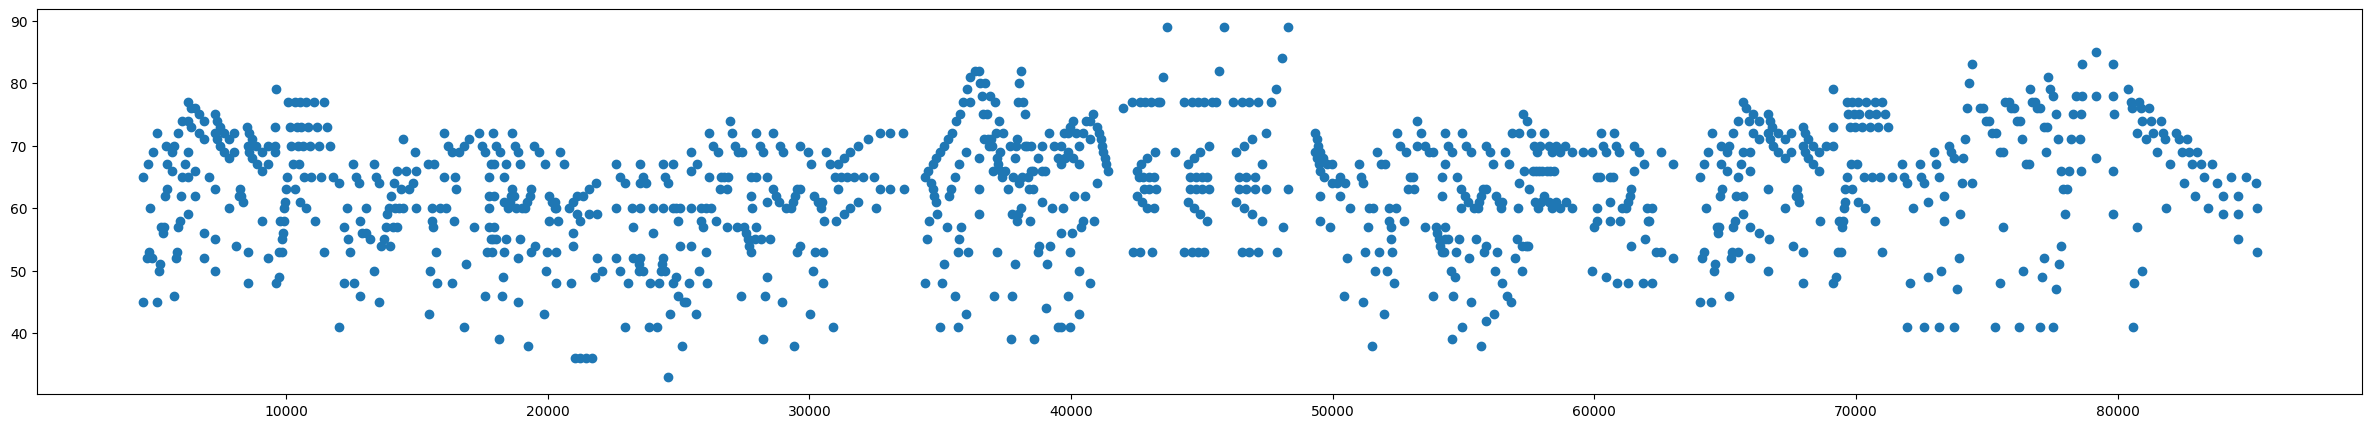

In [91]:
plt.figure(figsize=(30, 5))
plt.scatter(x, y)

In [96]:
os.makedirs('./labels/train')

In [97]:
image_fps = 25
sec_per_frame = 1 / image_fps
music_list = os.listdir("./images/train/")

for music in tqdm(music_list):
    frame_len = len(os.listdir(os.path.join("./images/train/", music)))
    music_idx = int(music.split("_")[0])
    label = np.zeros((frame_len, 88)) # top-down
    midi_idx = 0
    frame_time = 0.0
    
    mid = MidiFile(f'./pianoyt_MIDI/audio_{music_idx}.0.midi')
    
    bpm = mido.tempo2bpm(mid.tracks[0][0].tempo)
    bps = bpm / 60.0

    sec_per_tick = mid.ticks_per_beat * bps
    
    custom_notes = []
    curtime = 0
    for msg in mid.tracks[1]:
        if hasattr(msg, "note"):
            note_pitch = msg.note
            note_stat = "on" if msg.velocity > 0 else "off"
            curtime += msg.time
            note_time = curtime / sec_per_tick
            custom_notes.append({"status": note_stat, "note": note_pitch, "time(sec)":note_time})
            
    notes_only_on = [note for note in custom_notes if note['status'] == 'on']
    
    for i in range(frame_len):
        if midi_idx >= len(notes_only_on):
            break
        if notes_only_on[midi_idx]['time(sec)'] < frame_time:
            while midi_idx < len(notes_only_on) and notes_only_on[midi_idx]['time(sec)'] < frame_time:
                if notes_only_on[midi_idx]['note'] - 21 < 0:
                    print("minus")
                label[i][notes_only_on[midi_idx]['note'] - 21] = 1
                midi_idx += 1
        frame_time += sec_per_frame
        
    np.save(f"./labels/train/{music_idx}.npy", label)

  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [00:07<00:00,  4.36it/s]


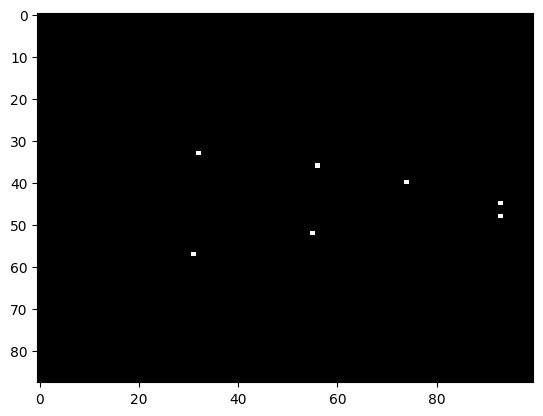

In [108]:
plt.imshow(label[250:350].transpose(), cmap='gray', aspect='auto')

In [110]:
label.shape

(12172, 88)

In [2]:
import pretty_midi
# Load MIDI file into PrettyMIDI object
midi_data = pretty_midi.PrettyMIDI('/opt/ml/ytdataset/pianoyt_MIDI/audio_100.0.midi')

In [3]:
piano_roll = midi_data.get_piano_roll()


In [5]:
piano_roll.shape

(128, 19804)

In [116]:
label_100 = np.load("/opt/ml/fianal_project/labels/train/100.npy")
label_100.shape

(5489, 88)

In [115]:
len(os.listdir("/opt/ml/fianal_project/images/train/100_Paul Rice “Waltz for Ella” FREE SHEET MUSIC P Barton FEURICH piano.mp4"))

5489

In [62]:
def pitch_time_to_piano_roll(pitch_time):
    num_pitches = 128
    num_keys = 88

    # 건반과 time 정보를 담을 numpy 배열 생성
    piano_roll = np.zeros((num_keys, pitch_time.shape[1]), dtype=bool)

    # 피치 정보를 건반 정보로 변환하여 piano_roll에 적용
    for i in range(num_keys):
        # 건반 범위에 해당하는 피치 인덱스 계산
        start_pitch = i
        end_pitch = start_pitch + num_pitches - num_keys

        # 건반 범위에 해당하는 피치 정보 추출
        key_pitches = pitch_time[start_pitch:end_pitch + 1, :]

        # 건반 범위에 해당하는 피치 정보를 합하여 건반 값으로 변환
        key_roll = np.sum(key_pitches, axis=0)

        # 건반 정보를 piano_roll에 적용
        piano_roll[i, :] = key_roll

    return piano_roll

In [78]:
key_piano_roll = pitch_time_to_piano_roll(piano_roll)

In [72]:
key_piano_roll[:, 5000]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

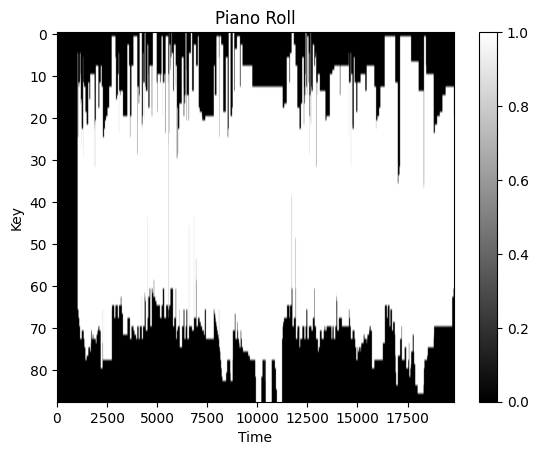

In [79]:
# 피아노 롤 시각화
plt.imshow(key_piano_roll, aspect='auto', cmap='gray')
plt.xlabel('Time')
plt.ylabel('Key')
plt.title('Piano Roll')
plt.colorbar()
plt.show()

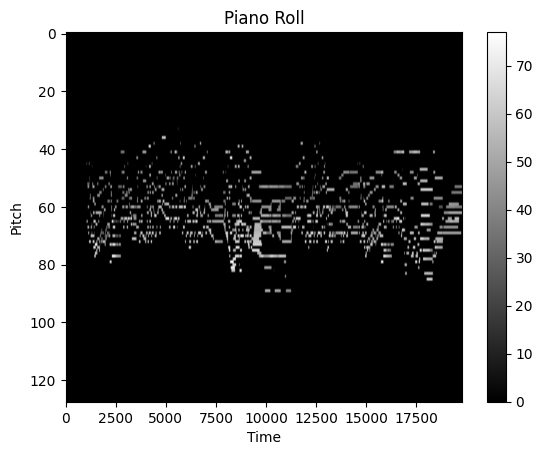

In [75]:
# 피아노 롤 시각화
plt.imshow(piano_roll, aspect='auto', cmap='gray')
plt.xlabel('Time')
plt.ylabel('Pitch')
plt.title('Piano Roll')
plt.colorbar()
plt.show()

In [47]:

np.min(piano_roll)

0.0

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.scatter(piano_roll)

TypeError: scatter() missing 1 required positional argument: 'y'

<Figure size 3000x500 with 0 Axes>